In [1]:
# !pip install python-binance
# !pip install python-dotenv
# !pip install pandas_ta

## Importações

In [2]:
from binance.client import Client
import pandas as pd
from dotenv import load_dotenv
import os
import pandas_ta as ta
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [4]:
load_dotenv()

API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")

## Verificando as Chaves

In [5]:
if not API_KEY or not API_SECRET:
    print("Erro: As chaves API_KEY ou API_SECRET não foram carregadas do arquivo .env.")
    print("Verifique se o arquivo .env existe na mesma pasta e se as variáveis estão corretas.")
    exit()

## Inicializando Cliente

In [7]:
try:
    client = Client(API_KEY, API_SECRET)
    print("Conexão com a Binance estabelecida com sucesso!")
except Exception as e:
    print(f"Erro ao conectar com a Binance: {e}")
    print("Verifique suas chaves de API e sua conexão com a internet.")
    exit()

Conexão com a Binance estabelecida com sucesso!


In [8]:
symbol = 'BTCUSDT'
interval = '1h'
limit = 2000

print(f"\nBuscando os últimos {limit} candlesticks de {symbol} no intervalo de {interval}...")


Buscando os últimos 2000 candlesticks de BTCUSDT no intervalo de 1h...


## Dados

In [9]:
klines = client.get_historical_klines(symbol, interval, limit=limit)

In [10]:
data = []
for kline in klines:
    data.append({
        'timestamp': kline[0],
        'open': float(kline[1]),
        'high': float(kline[2]),
        'low': float(kline[3]),
        'close': float(kline[4]),
        'volume': float(kline[5])
    })

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

df_original_cols = df.copy() # Cópia para ter os preços originais
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume'] # Renomeia para pandas_ta


In [11]:
df.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2025-06-28 03:00:00,107110.01,107347.10,107080.27,107300.13,142.29084
2025-06-28 04:00:00,107300.13,107310.90,107183.29,107191.19,92.66137
2025-06-28 05:00:00,107191.20,107317.00,107185.32,107294.80,127.55204
2025-06-28 06:00:00,107294.81,107449.07,107294.80,107412.07,119.62237
2025-06-28 07:00:00,107412.07,107496.12,107400.68,107485.00,157.78581


## Indicadores Técnicos

In [13]:
df.ta.sma(length=20, append=True)
df.ta.bbands(append=True)
df.ta.rsi(length=14, append=True)


timestamp
2025-06-28 03:00:00          NaN
2025-06-28 04:00:00          NaN
2025-06-28 05:00:00          NaN
2025-06-28 06:00:00          NaN
2025-06-28 07:00:00          NaN
                         ...    
2025-08-08 14:00:00    49.625905
2025-08-08 15:00:00    45.700194
2025-08-08 16:00:00    45.508152
2025-08-08 17:00:00    53.259410
2025-08-08 18:00:00    52.217658
Name: RSI_14, Length: 1000, dtype: float64

## Tratamento de Valores Nulos

In [14]:
initial_rows_before_nan = len(df)
df.dropna(inplace=True)
final_rows_after_nan = len(df)

## Criando os labels de Comprar/Vender/Manter

In [15]:
look_forward_period = 5
price_change_threshold = 0.005

df['future_close'] = df['Close'].shift(-look_forward_period)
df['price_change'] = (df['future_close'] - df['Close']) / df['Close']

def get_label(change, threshold):
    if change > threshold:
        return 1
    elif change < -threshold:
        return -1
    else:
        return 0

df['label'] = df['price_change'].apply(lambda x: get_label(x, price_change_threshold))

df.drop(columns=['future_close', 'price_change'], inplace=True)
df.dropna(inplace=True)

In [16]:
df.head()

,Open,High,Low,Close,Volume,SMA_20,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,RSI_14,label
timestamp,,,,,,,,,,,,,
2025-06-28 22:00:00,107331.37,107378.37,107257.09,107370.61,141.59714,107314.6190,107135.002597,107283.050,107431.097403,0.275994,0.795716,52.726745,0
2025-06-28 23:00:00,107370.61,107370.62,107282.72,107296.79,75.06468,107314.4520,107133.825644,107278.808,107423.790356,0.270291,0.562014,49.494623,0
2025-06-29 00:00:00,107296.79,107500.00,107254.16,107475.92,216.23676,107328.6885,107129.256875,107328.844,107528.431125,0.371917,0.868451,56.468018,0
2025-06-29 01:00:00,107475.91,107475.92,107310.53,107311.00,101.25733,107329.4985,107228.377493,107357.140,107485.902507,0.239877,0.320833,49.668510,0
2025-06-29 02:00:00,107311.00,107355.06,107172.52,107307.48,143.34108,107324.2690,107218.455482,107352.360,107486.264518,0.249467,0.332418,49.531419,0


## Criando X e y

In [17]:
X = df.drop(columns=['label'])
y = df['label']

## Escalonando

In [18]:
features_to_scale_final = X.columns.tolist()
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[features_to_scale_final]),
                        columns=features_to_scale_final,
                        index=X.index)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Treino e Teste

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)

## Otimização do modelo com GridSearchCV

In [51]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [50, 100], 
    'max_depth': [10, 20],
     'min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=0, n_jobs=-1) # Reduzindo cv e verbose
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'modelo_random_forest_otimizado.pkl')

['modelo_random_forest_otimizado.pkl']

## valiação do Melhor Modelo

In [52]:
loaded_scaler = joblib.load('scaler.pkl')
loaded_model = joblib.load('modelo_random_forest_otimizado.pkl')

y_pred_optimized = loaded_model.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"\nAcurácia do modelo otimizado no conjunto de teste: {accuracy_optimized:.4f}")
print("\nRelatório de Classificação do Modelo Otimizado:")
print(classification_report(y_test, y_pred_optimized))
print("\nMatriz de Confusão do Modelo Otimizado:")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)


Acurácia do modelo otimizado no conjunto de teste: 0.6548

Relatório de Classificação do Modelo Otimizado:
              precision    recall  f1-score   support

          -1       0.50      0.22      0.30        32
           0       0.70      0.88      0.78       129
           1       0.43      0.25      0.32        36

    accuracy                           0.65       197
   macro avg       0.54      0.45      0.47       197
weighted avg       0.62      0.65      0.62       197


Matriz de Confusão do Modelo Otimizado:


## Backtesting

In [53]:
initial_capital = 10000.0 # Capital inicial em USDT
position_size_percentage = 0.95 # % do capital para alocar em cada trade (ex: 95%)
commission_rate = 0.001 # Taxa de comissão da Binance (0.1% para maker/taker)

backtest_df = df.loc[X_test.index].copy() # Pega apenas as linhas que estão no X_test
backtest_df['predicted_label'] = y_pred_optimized # Adiciona as previsões do modelo
backtest_df['true_label'] = y_test # Adiciona os labels reais para comparação

capital = initial_capital
position = 0.0 # Quantidade do ativo base que temos (ex: BTC)
in_position = False # Flag para saber se estamos comprados

trade_log = [] # Para registrar os trades

print(f"Capital inicial: {capital:.2f} USDT")

Capital inicial: 10000.00 USDT


In [54]:
for index, row in backtest_df.iterrows():
    current_price = row['Close'] # Preço de fechamento real do candle
    prediction = row['predicted_label'] # Previsão do nosso modelo

    # Lógica de Compra
    if prediction == 1 and not in_position: # Se o modelo previu "comprar" e não estamos em posição
        amount_to_buy_usdt = capital * position_size_percentage
        if amount_to_buy_usdt > 0:
            qty_to_buy = amount_to_buy_usdt / current_price
            commission_cost = qty_to_buy * current_price * commission_rate
            
            capital -= (qty_to_buy * current_price) + commission_cost
            position += qty_to_buy
            in_position = True
            
            trade_log.append({
                'timestamp': index,
                'type': 'BUY',
                'price': current_price,
                'qty': qty_to_buy,
                'commission': commission_cost,
                'capital_after_trade': capital,
                'position_after_trade': position
            })
            # print(f"{index}: BUY @ {current_price:.2f} | Capital: {capital:.2f} | Pos: {position:.4f}")

    # Lógica de Venda
    elif prediction == -1 and in_position: # Se o modelo previu "vender" e estamos em posição
        commission_cost = position * current_price * commission_rate
        
        capital += (position * current_price) - commission_cost
        position = 0.0
        in_position = False
        
        trade_log.append({
            'timestamp': index,
            'type': 'SELL',
            'price': current_price,
            'qty': position, # Qtde vendida é a que tínhamos
            'commission': commission_cost,
            'capital_after_trade': capital,
            'position_after_trade': position
        })       

In [55]:
if in_position:
    commission_cost = position * backtest_df.iloc[-1]['Close'] * commission_rate
    capital += (position * backtest_df.iloc[-1]['Close']) - commission_cost
    position = 0.0
    print(f"Venda final da posição no último preço: {backtest_df.iloc[-1]['Close']:.2f}")

final_capital = capital
profit_loss_usd = final_capital - initial_capital
profit_loss_percent = (profit_loss_usd / initial_capital) * 100

print("\n--- Resultados do Backtest ---")
print(f"Capital inicial: {initial_capital:.2f} USDT")
print(f"Capital final: {final_capital:.2f} USDT")
print(f"Lucro/Prejuízo: {profit_loss_usd:.2f} USDT")
print(f"Retorno percentual: {profit_loss_percent:.2f}%")
print(f"Número total de trades: {len(trade_log)}")


Venda final da posição no último preço: 116543.58

--- Resultados do Backtest ---
Capital inicial: 10000.00 USDT
Capital final: 12072.89 USDT
Lucro/Prejuízo: 2072.89 USDT
Retorno percentual: 20.73%
Número total de trades: 17


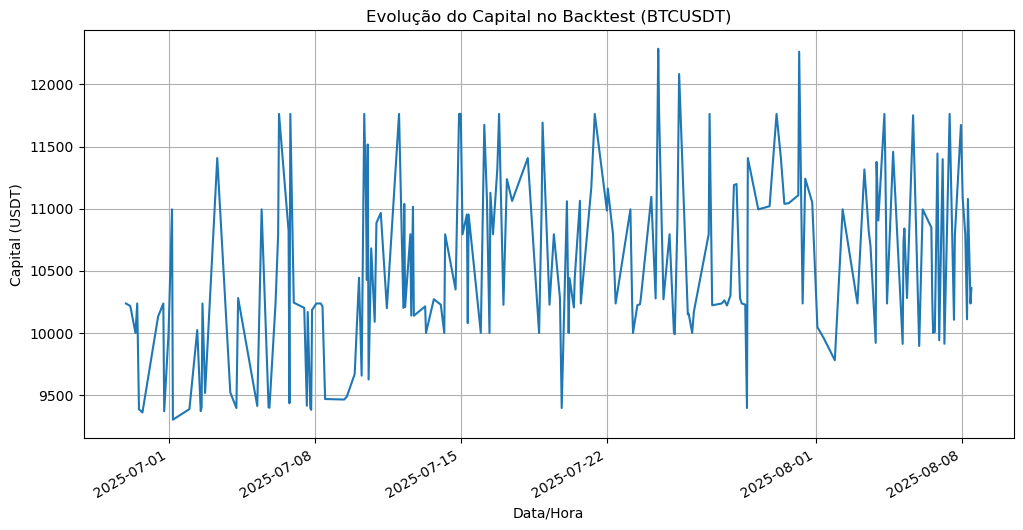

In [56]:
if len(trade_log) > 0:
    trade_df = pd.DataFrame(trade_log)
    trade_df.set_index('timestamp', inplace=True)
    
    # Para visualizar a evolução do capital, precisamos preencher entre os trades
    # Criar uma série para o capital ao longo do tempo
    capital_history = pd.Series(index=backtest_df.index, dtype=float)
    current_capital_viz = initial_capital
    current_position_viz = 0.0
    
    for index_df, row_df in backtest_df.iterrows():
        # Se houve trade nesse timestamp, atualiza o capital e posição
        trade_at_ts = trade_df[trade_df.index == index_df]
        if not trade_at_ts.empty:
            current_capital_viz = trade_at_ts.iloc[0]['capital_after_trade']
            current_position_viz = trade_at_ts.iloc[0]['position_after_trade']
            
        # Calcula o valor total do portfólio (capital + valor da posição)
        portfolio_value = current_capital_viz + (current_position_viz * row_df['Close'])
        capital_history.loc[index_df] = portfolio_value
        
    plt.figure(figsize=(12, 6))
    capital_history.plot(title=f'Evolução do Capital no Backtest ({symbol})')
    plt.xlabel('Data/Hora')
    plt.ylabel('Capital (USDT)')
    plt.grid(True)
    plt.show()
else:
    print("Nenhum trade foi executado durante o backtest.")